# core

> Fill in a module description here

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
class Preprocess:
    def __init__(self, clahe=True):
        self.clahe = clahe

    def run(self, image):
        if self.clahe:
            image = self.CLAHE(image)
        return image

    def CLAHE(image, clip_limit, tile_grid_size):
        """
        Applies CLAHE to a single image.

        :param image (numpy.ndarray): The input image.
        :param clip_limit (float): Clip limit for CLAHE. Higher values result in stronger contrast enhancement.
        :param tile_grid_size (tuple): Size of the tiles for CLAHE.

        Returns:
            numpy.ndarray: The CLAHE-enhanced image.
        """

        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        enhanced_image = clahe.apply(image)
        return enhanced_image
    
class Tiles:
    def __init__(self, tile_size, overlap, tile_all):
        self.tile_size = tile_size
        self.overlap = overlap
        self.tile_all = tile_all

    def count(image, t=1024, v=0.1):
        """
        Calculates the number of tiles in X and Y direcitons.

        :param image: input image.
        :param t: length of a tile (usually 1024)
        :param v: percent overlap between tiles (10% be default in Leica LASX)

        Returns: integer: number of tiles
        """
        X = image.shape[0]
        Y = image.shape[1]
        n_tiles_X = round(((X/t)-v)/(1-v))
        n_tiles_Y = round(((Y/t)-v)/(1-v))
        return (n_tiles_X, n_tiles_Y)
    
    def split(image, tile_size, overlap, tile_all=True):
        """
        Splits an image into smaller tiles of size `tile_size` with `overlap` pixels between them.
        
        :param image: input image.
        :param tile_size: Tuple (n, n) specifying the size of each tile.
        :param overlap: Number of pixels to overlap between tiles.
        :param tile_all: Boolean, set to True to handle the edges and make sure that the entire image is tiled.
        """
        
        img_height, img_width = image.shape[:2]  # Handle grayscale or RGB images
        
        tile_h, tile_w = tile_size
        
        # Compute the step size considering the overlap
        step_h = tile_h - overlap
        step_w = tile_w - overlap
        
        tile_id = 0
        
        y_range = list(itertools.chain(range(0, img_height - tile_h + 1, step_h), [img_height - tile_h]) if tile_all else range(0, img_height - tile_h + 1, step_h))
        x_range = list(itertools.chain(range(0, img_width - tile_w + 1, step_w), [img_width - tile_w]) if tile_all else range(0, img_width - tile_w + 1, step_w))
        
        all_tiles = []
        y_pos = []
        x_pos = []
        for y in y_range:
            for x in x_range:
                tile = image[y:y+tile_h, x:x+tile_w]
                all_tiles.append(tile)
                y_pos.append(y)
                x_pos.append(x)
                tile_id += 1
                
                    
        all_tiles = np.array(all_tiles)
        return((all_tiles, x_pos, y_pos))
    
    def stitch(tiles, iou_threshold=0.5):
        """
        Stitches together several tile masks into a large global mask using IoU matching.
        
        Each tile is a dictionary with keys:
        - "mask": 2D NumPy array with 0 for background and positive integers for cells.
        - "x": x-coordinate (column index) of the tile's top-left corner in the global image.
        - "y": y-coordinate (row index) of the tile's top-left corner in the global image.
        
        Parameters:
        tiles (list of dict): List of tile dictionaries as described.
        iou_threshold (float): Minimum IoU required to consider a match between a tile cell 
                                and a global cell in the overlapping region.
        
        Returns:
        global_mask (2D NumPy array): A stitched mask with unique cell labels (1, 2, 3, ...).
        """
        
        # 1. Determine the dimensions of the output global mask.
        max_y = max(tile["y"] + tile["mask"].shape[0] for tile in tiles)
        max_x = max(tile["x"] + tile["mask"].shape[1] for tile in tiles)
        global_mask = np.zeros((max_y, max_x), dtype=np.int32)
        
        next_global_label = 1  # Global labels will be assigned starting at 1.
        
        # 2. Process the first tile by assigning new global labels for every nonzero cell.
        first_tile = tiles[0]
        tile_mask = first_tile["mask"]
        tile_y, tile_x = first_tile["y"], first_tile["x"]
        h, w = tile_mask.shape
        
        # Create a mapping for the first tile: every (nonzero) tile cell gets a new global label.
        mapping = {}
        for lab in np.unique(tile_mask):
            if lab == 0:
                continue
            mapping[lab] = next_global_label
            next_global_label += 1

        # Remap the tile's mask using the mapping.
        remapped_tile = np.where(tile_mask != 0,
                                np.vectorize(lambda x: mapping.get(x, 0))(tile_mask),
                                0)
        
        # Paste the remapped tile into the global mask.
        global_mask[tile_y:tile_y+h, tile_x:tile_x+w] = remapped_tile

        # 3. Process subsequent tiles.
        for tile in tiles[1:]:
            tile_mask = tile["mask"]
            tile_y, tile_x = tile["y"], tile["x"]
            h, w = tile_mask.shape
            
            # Extract the corresponding region from the global mask.
            global_region = global_mask[tile_y:tile_y+h, tile_x:tile_x+w].copy()
            
            # Determine the overlapping region where both the new tile and the global mask are nonzero.
            overlap_mask = (global_region != 0) & (tile_mask != 0)
            
            # Retrieve the unique cell labels present in the overlapping area.
            # Since overlap_mask ensures both are nonzero, these will be valid cell labels.
            global_overlap_labels = np.unique(global_region[overlap_mask])
            tile_overlap_labels   = np.unique(tile_mask[overlap_mask])
            
            # Build a mapping between tile labels and global labels for the overlapping region.
            mapping_tile_to_global = {}  # mapping: tile cell label -> global cell label
            
            # If there are overlapping cell labels in both the tile and the global mask,
            # compute the IoU for each pair.
            if global_overlap_labels.size > 0 and tile_overlap_labels.size > 0:
                n_tile = len(tile_overlap_labels)
                n_global = len(global_overlap_labels)
                iou_matrix = np.zeros((n_tile, n_global), dtype=float)
                
                # Loop over each pair of tile cell and global cell in the overlap.
                for i, t_lab in enumerate(tile_overlap_labels):
                    # Create a mask for the tile cell in the entire tile.
                    tile_cell_mask = (tile_mask == t_lab)
                    for j, g_lab in enumerate(global_overlap_labels):
                        global_cell_mask = (global_region == g_lab)
                        # Compute intersection and union in the overlapping region.
                        intersection = np.sum(tile_cell_mask & global_cell_mask)
                        union = np.sum(tile_cell_mask | global_cell_mask)
                        iou = intersection / union if union > 0 else 0
                        iou_matrix[i, j] = iou
                
                # Create a cost matrix to maximize IoU via minimization (negative IoU).
                cost_matrix = -iou_matrix
                row_ind, col_ind = linear_sum_assignment(cost_matrix)
                # Accept assignments only if they meet or exceed the IoU threshold.
                for r, c in zip(row_ind, col_ind):
                    if iou_matrix[r, c] >= iou_threshold:
                        mapping_tile_to_global[tile_overlap_labels[r]] = global_overlap_labels[c]
            
            # For any tile cell not assigned a global label (or outside the overlapping regions),
            # assign a new global label.
            for lab in np.unique(tile_mask):
                if lab == 0:
                    continue
                if lab not in mapping_tile_to_global:
                    mapping_tile_to_global[lab] = next_global_label
                    next_global_label += 1

            # Remap the entire tile mask using the computed mapping.
            remapped_tile = np.where(tile_mask != 0,
                                    np.vectorize(lambda x: mapping_tile_to_global.get(x, 0))(tile_mask),
                                    0)
            
            # Update the global mask:
            # Only update pixels in the global region that are still background (0)
            # to avoid overwriting already-assigned labels.
            region_mask = (remapped_tile != 0)
            update_mask = (global_region == 0) & region_mask
            global_region[update_mask] = remapped_tile[update_mask]
            # Write the updated region back to the global mask.
            global_mask[tile_y:tile_y+h, tile_x:tile_x+w] = global_region

        return global_mask
    


In [ ]:

import tifffile as tiff
import cv2

filename = "/Users/mzarodniuk/Documents/SAI/NDSAI_analysis/data/raw/01-29-25_PDPN_ERTR7_10um-selected/01-29-25_PDPN_ERTR7_49-2-1_NEG_Merged_ch00.tif"
image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

In [ ]:
image_enh = Preprocess.CLAHE(image = image,
                            clip_limit = 4,
                            tile_grid_size = Tiles.count(image))

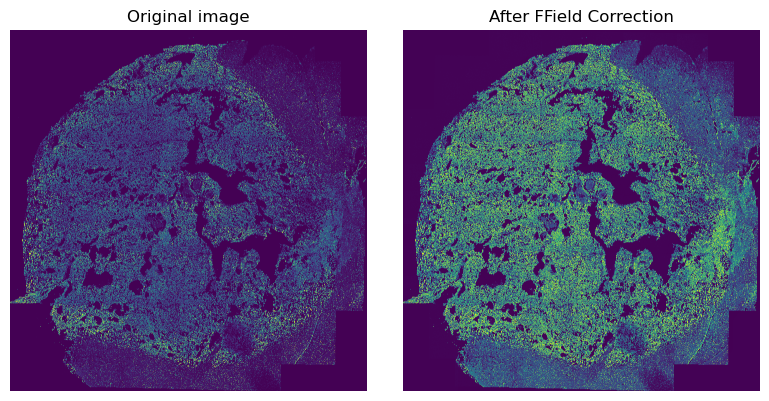

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.imshow(image)
ax1.set_title('Original image')
ax1.axis('off')

ax2.imshow(image_enh)
ax2.set_title('After FField Correction')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import itertools
import numpy as np
import os

tiles, x, y = Tiles.split(image_enh, (128, 128), 13)
output_dir = "/Users/mzarodniuk/Documents/SAI/NDSAI_analysis/testing"

for tile_id, tile in enumerate(tiles):
    tile_filename = f"{os.path.splitext(os.path.basename(filename))[0]}_tile_{tile_id:04d}_x_{x[tile_id]}_y_{y[tile_id]}.tif"  # Adjust naming scheme as needed
    tile_path = os.path.join(output_dir, tile_filename)
    tiff.imwrite(tile_path, tile)

In [ ]:
print(tile_path)

/Users/mzarodniuk/Documents/SAI/NDSAI_analysis/data/raw/01-29-25_PDPN_ERTR7_10um-selected/01-29-25_PDPN_ERTR7_49-2-1_NEG_Merged_ch00_tile_11129_x_11881_y_12020.tif


In [ ]:
from cellpose import models, io

model_ft = models.CellposeModel(gpu=True, pretrained_model="/Users/mzarodniuk/Documents/SAI/NDSAI_analysis/data/testing/all/models/CP_20250401_185118")
mask, flow, style = model_ft.eval(list(tiles), flow_threshold=0.32, cellprob_threshold=0.08, channels=[0,0],)

no seeds found in get_masks_torch - no masks found.
no seeds found in get_masks_torch - no masks found.
no seeds found in get_masks_torch - no masks found.
no seeds found in get_masks_torch - no masks found.
no seeds found in get_masks_torch - no masks found.
no seeds found in get_masks_torch - no masks found.
no seeds found in get_masks_torch - no masks found.
no seeds found in get_masks_torch - no masks found.
no seeds found in get_masks_torch - no masks found.
no seeds found in get_masks_torch - no masks found.


KeyboardInterrupt: 

In [ ]:
list(tiles)[0].shape

(128, 128)

In [ ]:
save output of model eval to be loaded in GUI
io.masks_flows_to_seg(images = tiles, masks = mask, flows = flow, diams = [0 for i in range(len(files))], file_names=sorted(files), channels=[0,0])